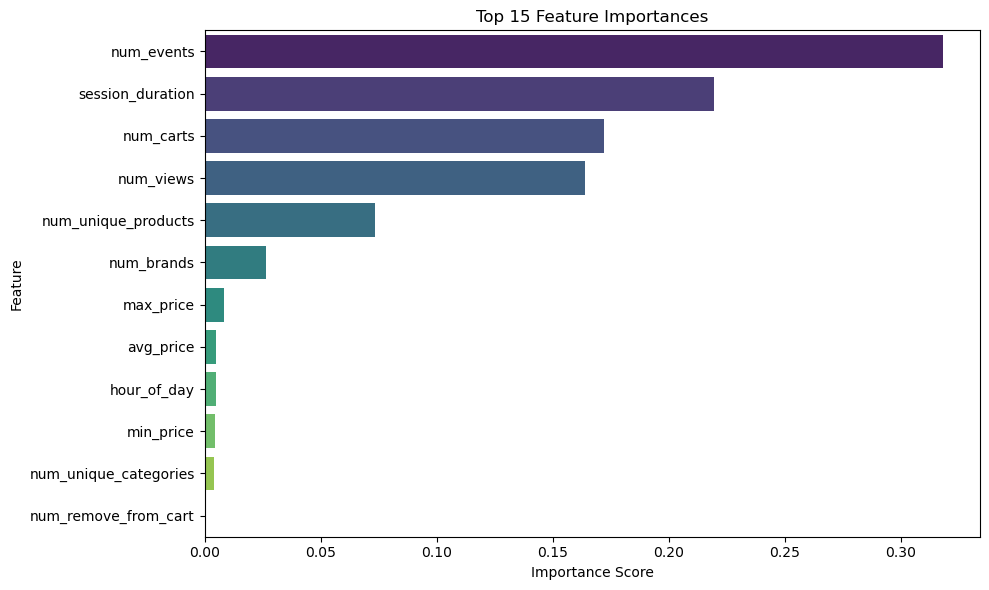

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load your trained model and scaler
model = joblib.load("purchase_model.pkl")  # update path if needed
scaler = joblib.load("scaler.pkl")

# Load your feature dataset
df = pd.read_csv(r"D:\Sparkathon\Data\phase2_Oct_session_features.csv")
X = df.drop(columns=['user_session', 'user_id', 'session_start', 'session_end', 'made_purchase'], errors='ignore')

# Plot top 15 important features
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    feature_names = X.columns
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices][:15], y=feature_names[indices][:15], palette="viridis")
    plt.title("Top 15 Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig('Feature Importance.png')
    plt.show()


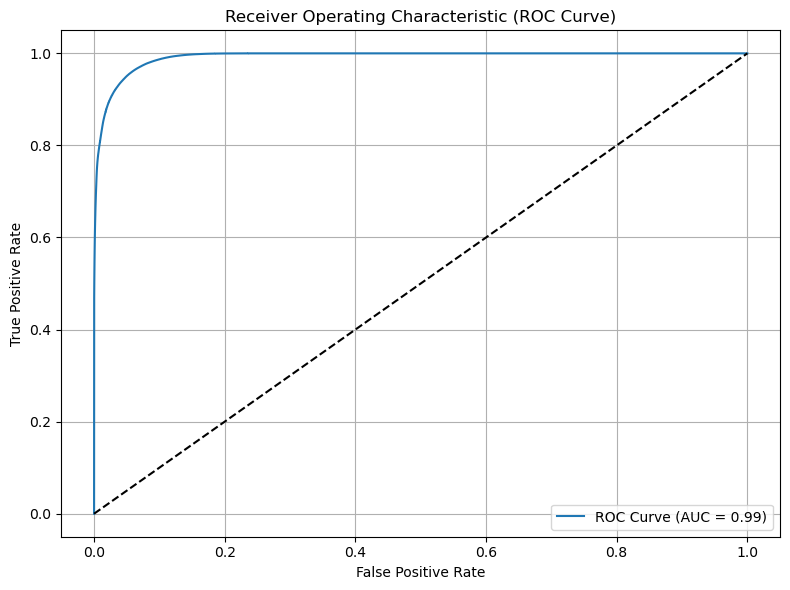

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import joblib

# Load your model and scaler
model = joblib.load("purchase_model.pkl")
scaler = joblib.load("scaler.pkl")

# Load the dataset used for evaluation (or test set)
df = pd.read_csv(r"D:\Sparkathon\Data\phase2_Oct_session_features.csv")

# Define features and target
X = df.drop(columns=[
    'user_session', 'user_id', 'session_start', 'session_end', 'made_purchase'
], errors='ignore')
y = df['made_purchase']

# Scale features
X_scaled = scaler.transform(X)

# Compute ROC values
y_proba = model.predict_proba(X_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC Curve)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC Curve.png')
plt.show()

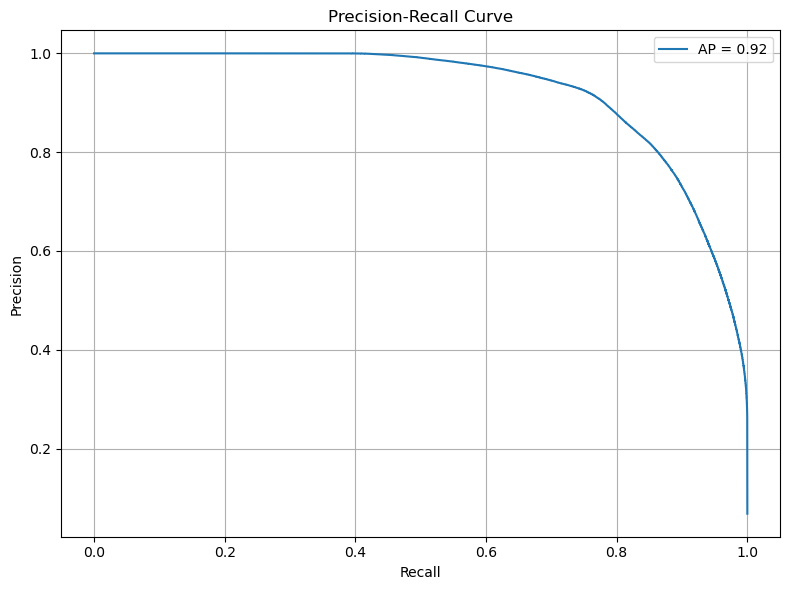

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y, y_proba)
avg_prec = average_precision_score(y, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_prec:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Precision-Recall Curve.png')
plt.show()


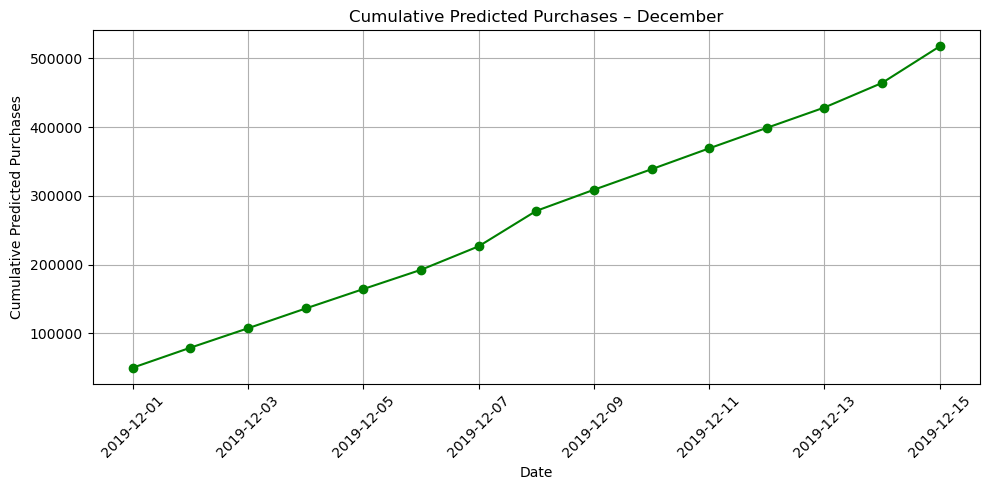

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

forecast_df = pd.read_csv("dec_forecast_only.csv", parse_dates=["date"])
forecast_df["cumulative_predicted"] = forecast_df["predicted_purchases"].cumsum()

plt.figure(figsize=(10, 5))
plt.plot(forecast_df["date"], forecast_df["cumulative_predicted"], color='green', marker='o')
plt.title("Cumulative Predicted Purchases – December")
plt.xlabel("Date")
plt.ylabel("Cumulative Predicted Purchases")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Cumulative Predicted Purchases – December.png')
plt.show()


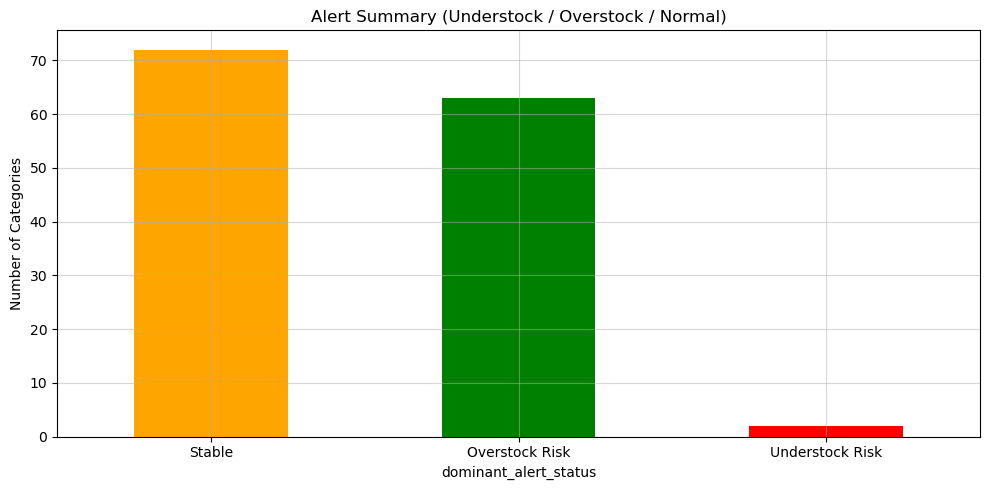

In [27]:
alert_df = pd.read_csv(r"D:\Sparkathon\Notebooks\phase4_outputs\phase4_alert_summary.csv")

plt.figure(figsize=(10, 5))
alert_counts = alert_df['dominant_alert_status'].value_counts()
alert_counts.plot(kind='bar', color=['orange', 'green', 'red'])
plt.title("Alert Summary (Understock / Overstock / Normal)")
plt.ylabel("Number of Categories")
plt.xticks(rotation=0)
plt.grid(True,alpha=0.5)
plt.tight_layout()
plt.savefig('Number of Categories.png')
plt.show()


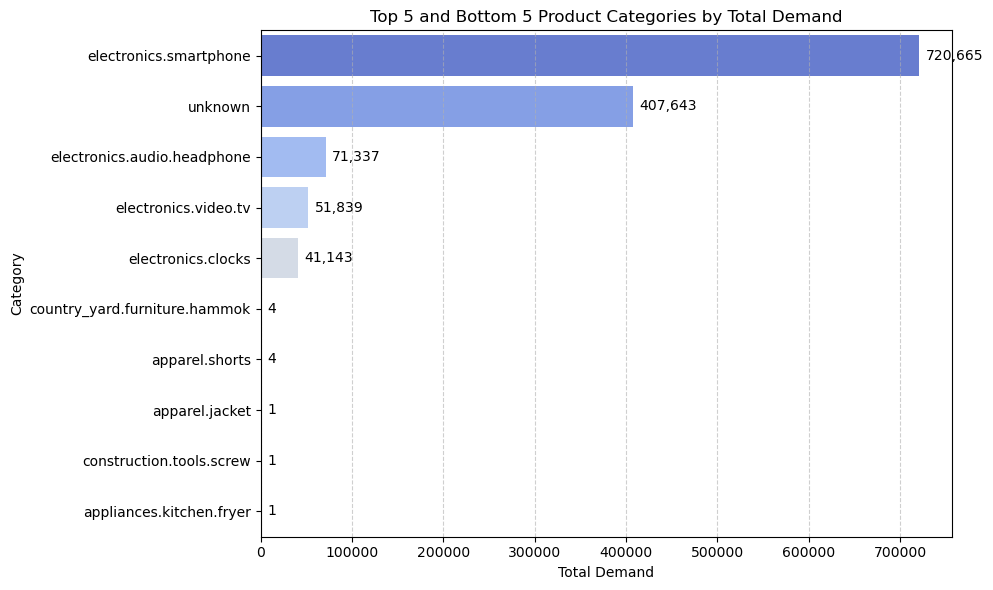

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"D:\Sparkathon\Data\aggregated_category_demand.csv")
df['category_code'] = df['category_code'].astype(str).str.lower()

category_demand = df.groupby('category_code')['y'].sum().sort_values(ascending=False)

top_5 = category_demand.head(5)
bottom_5 = category_demand.tail(5)

combined = pd.concat([top_5, bottom_5])
combined_df = combined.reset_index()
combined_df.columns = ['Category', 'Total_Demand']

plt.figure(figsize=(10, 6))
sns.barplot(data=combined_df, x='Total_Demand', y='Category', palette='coolwarm')
plt.title("Top 5 and Bottom 5 Product Categories by Total Demand")
plt.xlabel("Total Demand")
plt.ylabel("Category")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

for i, v in enumerate(combined_df['Total_Demand']):
    plt.text(v + max(combined_df['Total_Demand']) * 0.01, i, f"{int(v):,}", va='center')

plt.tight_layout()
plt.savefig("Top_Bottom_Categories_BarChart.png")
plt.show()

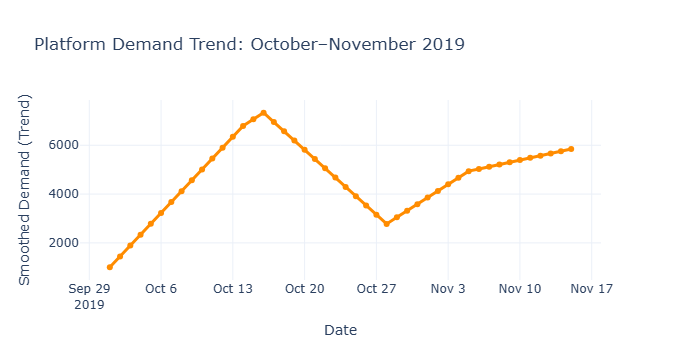

In [53]:
import pandas as pd
import joblib
import plotly.graph_objs as go
from prophet import Prophet

model = joblib.load("phase3b_prophet_model.pkl")
history = model.history[['ds', 'y']].copy()
forecast = model.predict(history[['ds']])
history['trend'] = forecast['trend']
history_oct_nov = history[(history['ds'] >= '2019-10-01') & (history['ds'] <= '2019-11-30')]

fig = go.Figure()
fig.add_trace(go.Scatter(
x=history_oct_nov['ds'],
y=history_oct_nov['trend'],
mode='lines+markers',
name='Trend (Oct–Nov)',
line=dict(color='darkorange', width=3)
))

fig.update_layout(
title='Platform Demand Trend: October–November 2019',
xaxis_title='Date',
yaxis_title='Smoothed Demand (Trend)',
template='plotly_white',
hovermode='x unified'
)

fig.show() 

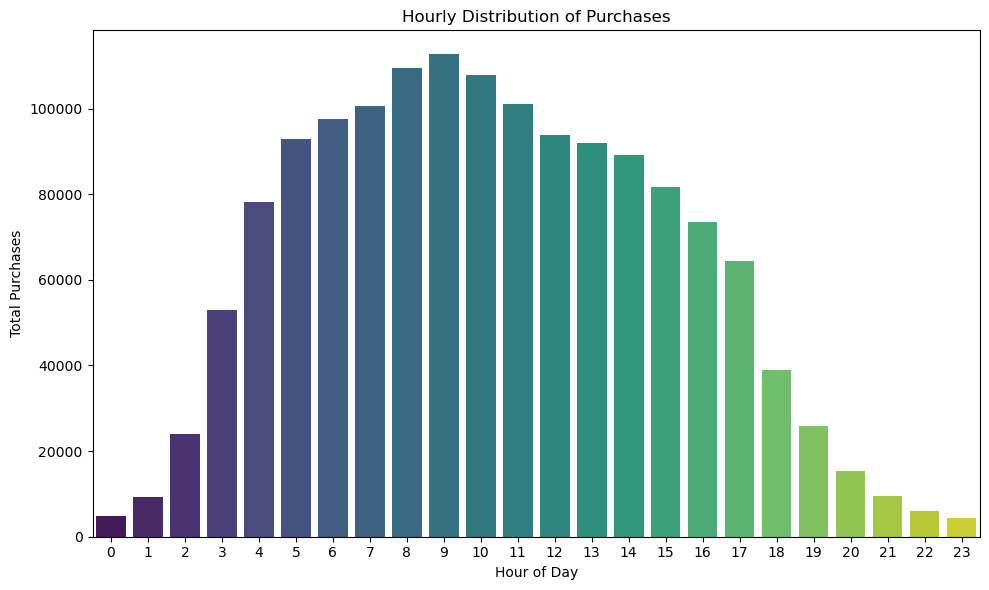

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("D:/Sparkathon/Data/phase2_OctNov_combined_session_features.csv", parse_dates=["session_start"])
df["hour"] = df["session_start"].dt.hour
hourly = df.groupby("hour")["made_purchase"].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=hourly, x="hour", y="made_purchase", palette="viridis")
plt.title("Hourly Distribution of Purchases")
plt.xlabel("Hour of Day")
plt.ylabel("Total Purchases")
plt.tight_layout()
plt.savefig("hourly_activity_distribution.png")
plt.show()

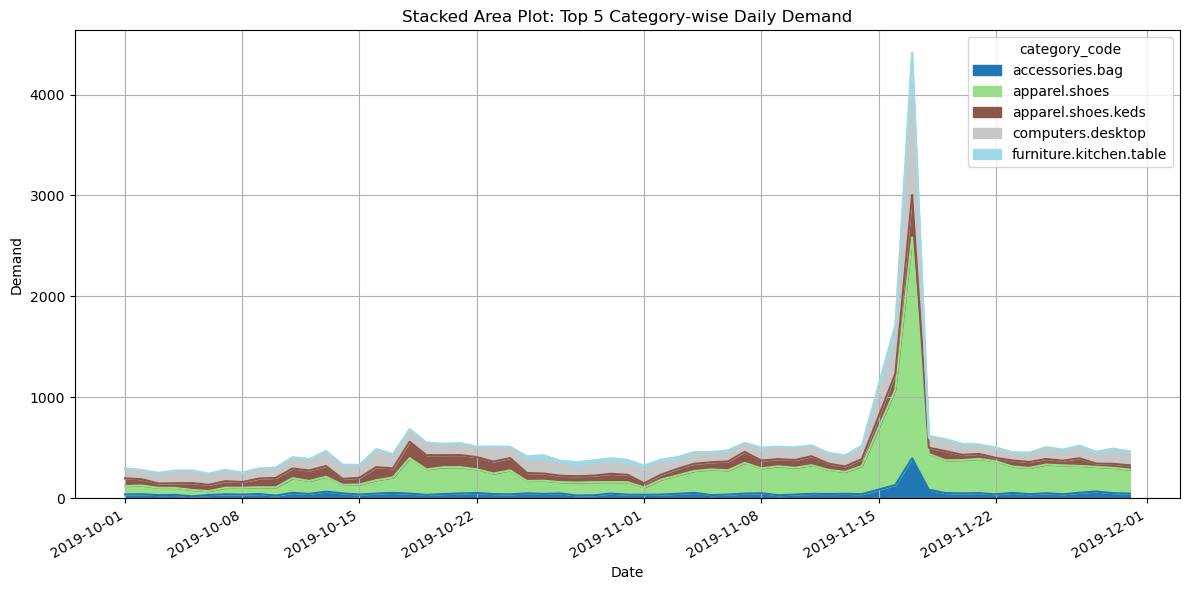

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r"D:\Sparkathon\Data\aggregated_category_demand.csv", parse_dates=["ds"])
df["category_code"] = df["category_code"].astype(str).str.lower()
df = df[df["category_code"] != "unknown"]

top_cats = df["category_code"].value_counts().nlargest(5).index
df_top = df[df["category_code"].isin(top_cats)]

pivot_df = df_top.pivot_table(index="ds", columns="category_code", values="y", aggfunc="sum").fillna(0)

pivot_df.plot.area(figsize=(12, 6), colormap='tab20')
plt.title("Stacked Area Plot: Top 5 Category-wise Daily Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.grid(True)
plt.tight_layout()
plt.savefig("stacked_area_plot_top5.png")
plt.show()